## Data Cleaning

Dans un premier temps, on écrit et exécute tout les imports qu'on a besoin pour nettoyer les données

In [69]:
from sklearn.base import TransformerMixin  # gives fit_transform method for free
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, MultiLabelBinarizer
from sklearn.preprocessing import Imputer, OrdinalEncoder
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values


class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = MultiLabelBinarizer(*args, **kwargs)

    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self

    def transform(self, x, y=0):
        return self.encoder.transform(x)


On a crée une classe Data_cleaning qui s'occupe de nettoyer les données en une fois.

Afin de cleaner les datas, nous avons utilisé un pipeline.
Pour utiliser ce pipeline, on a séparé les datas en 2 catégories :
    1. les variables numériques ( de type float64 ou int64 )
    2. les variables catégorielles ( la saison dans ce cas-ci )
    
- Les variables numériques
    
    2 questions se sont posés à nous :
    
    1. Comment s'occuper des données manquantes NaN ?
    2. Quelle méthode choisir entre MinMaxScaler() et StandarScaler() pour la mise à l'échelle des données
    
    Pour la question 1, nous avons choisit d'utiliser la classe Imputer qui se charge des données manquantes en spécifiant         paramètre "strategy = median" qui permet de changer un donnée null en une valeur qui est la médianne des autres données         pour la variable présentant des données manquantes.
    
    Pour la question 2 vers cellule juste en dessous.
    

- les variables catégorielles

    On applique un multiLabelBinazer pour pouvoir utiliser les variables catégorielles dans le modèle.


### MinMaxScaler ou StandardScaler

Standardscaler:

1.In Standardscaler, it assumes that data has normally distributed features and will scale them to zero mean and 1 standard deviation.

2.All the features will be of the same scale after applying the scaler.

Minmaxscaler :

1.Minmaxscaler  shrinks the data within the range of -1 to 1(if there are negative values)

2. This responds well if standard deviation is small and  is used when distribution is not Gaussian.This scaler is sensitive to outliers.


source : https://intellipaat.com/community/9629/difference-between-standard-scaler-and-minmaxscaler

Nous allons donc ploter les différentes variables numériques.

Mais dans un premier temps, nous prenons un dataframe sur lequel on a appliqué l'engineering.Et on sélectionne les colonnes contenant des données de types réels mise sous forme de variables continues.



In [82]:
import pandas as pd
from sklearn.pipeline import FeatureUnion

matchsTrain = pd.read_csv('./csv/matchsTrainFinal.csv')

matchsTrain.drop(columns=['Unnamed: 0','index'],inplace=True)


matchsTrainNumVariables = matchsTrain.iloc[:,7:16]

colLabels = matchsTrainNumVariables.columns

matchsTrainNumVariables.head()





,diff_build_up,diff_def_press,diff_def_overall,diff_mid_overall,diff_att_overall,diff_att_home_def_away,diff_def_home_att_away,diff_def_pot,diff_mid_pot
0,-0.050505,-0.202020,-0.037374,-0.037879,-0.088384,-0.043434,-0.082323,-0.067677,-0.031566
1,0.000000,-0.202020,0.023232,-0.047980,-0.042929,0.112121,-0.131818,-0.013131,-0.079545
2,0.151515,0.000000,0.042424,0.008081,0.035354,0.014141,0.063636,0.019192,0.006061
3,-0.050505,-0.101010,-0.049495,-0.065657,-0.080808,-0.036364,-0.093939,-0.073737,-0.077020
4,-0.131313,0.030303,-0.050188,-0.068735,0.146970,0.185166,-0.088384,-0.050361,-0.050274


## Data Visualization


### Boxplot pour visualiser si présences d'outliers

Les outliers sont indiqué sur le graphe par des losanges noirs.

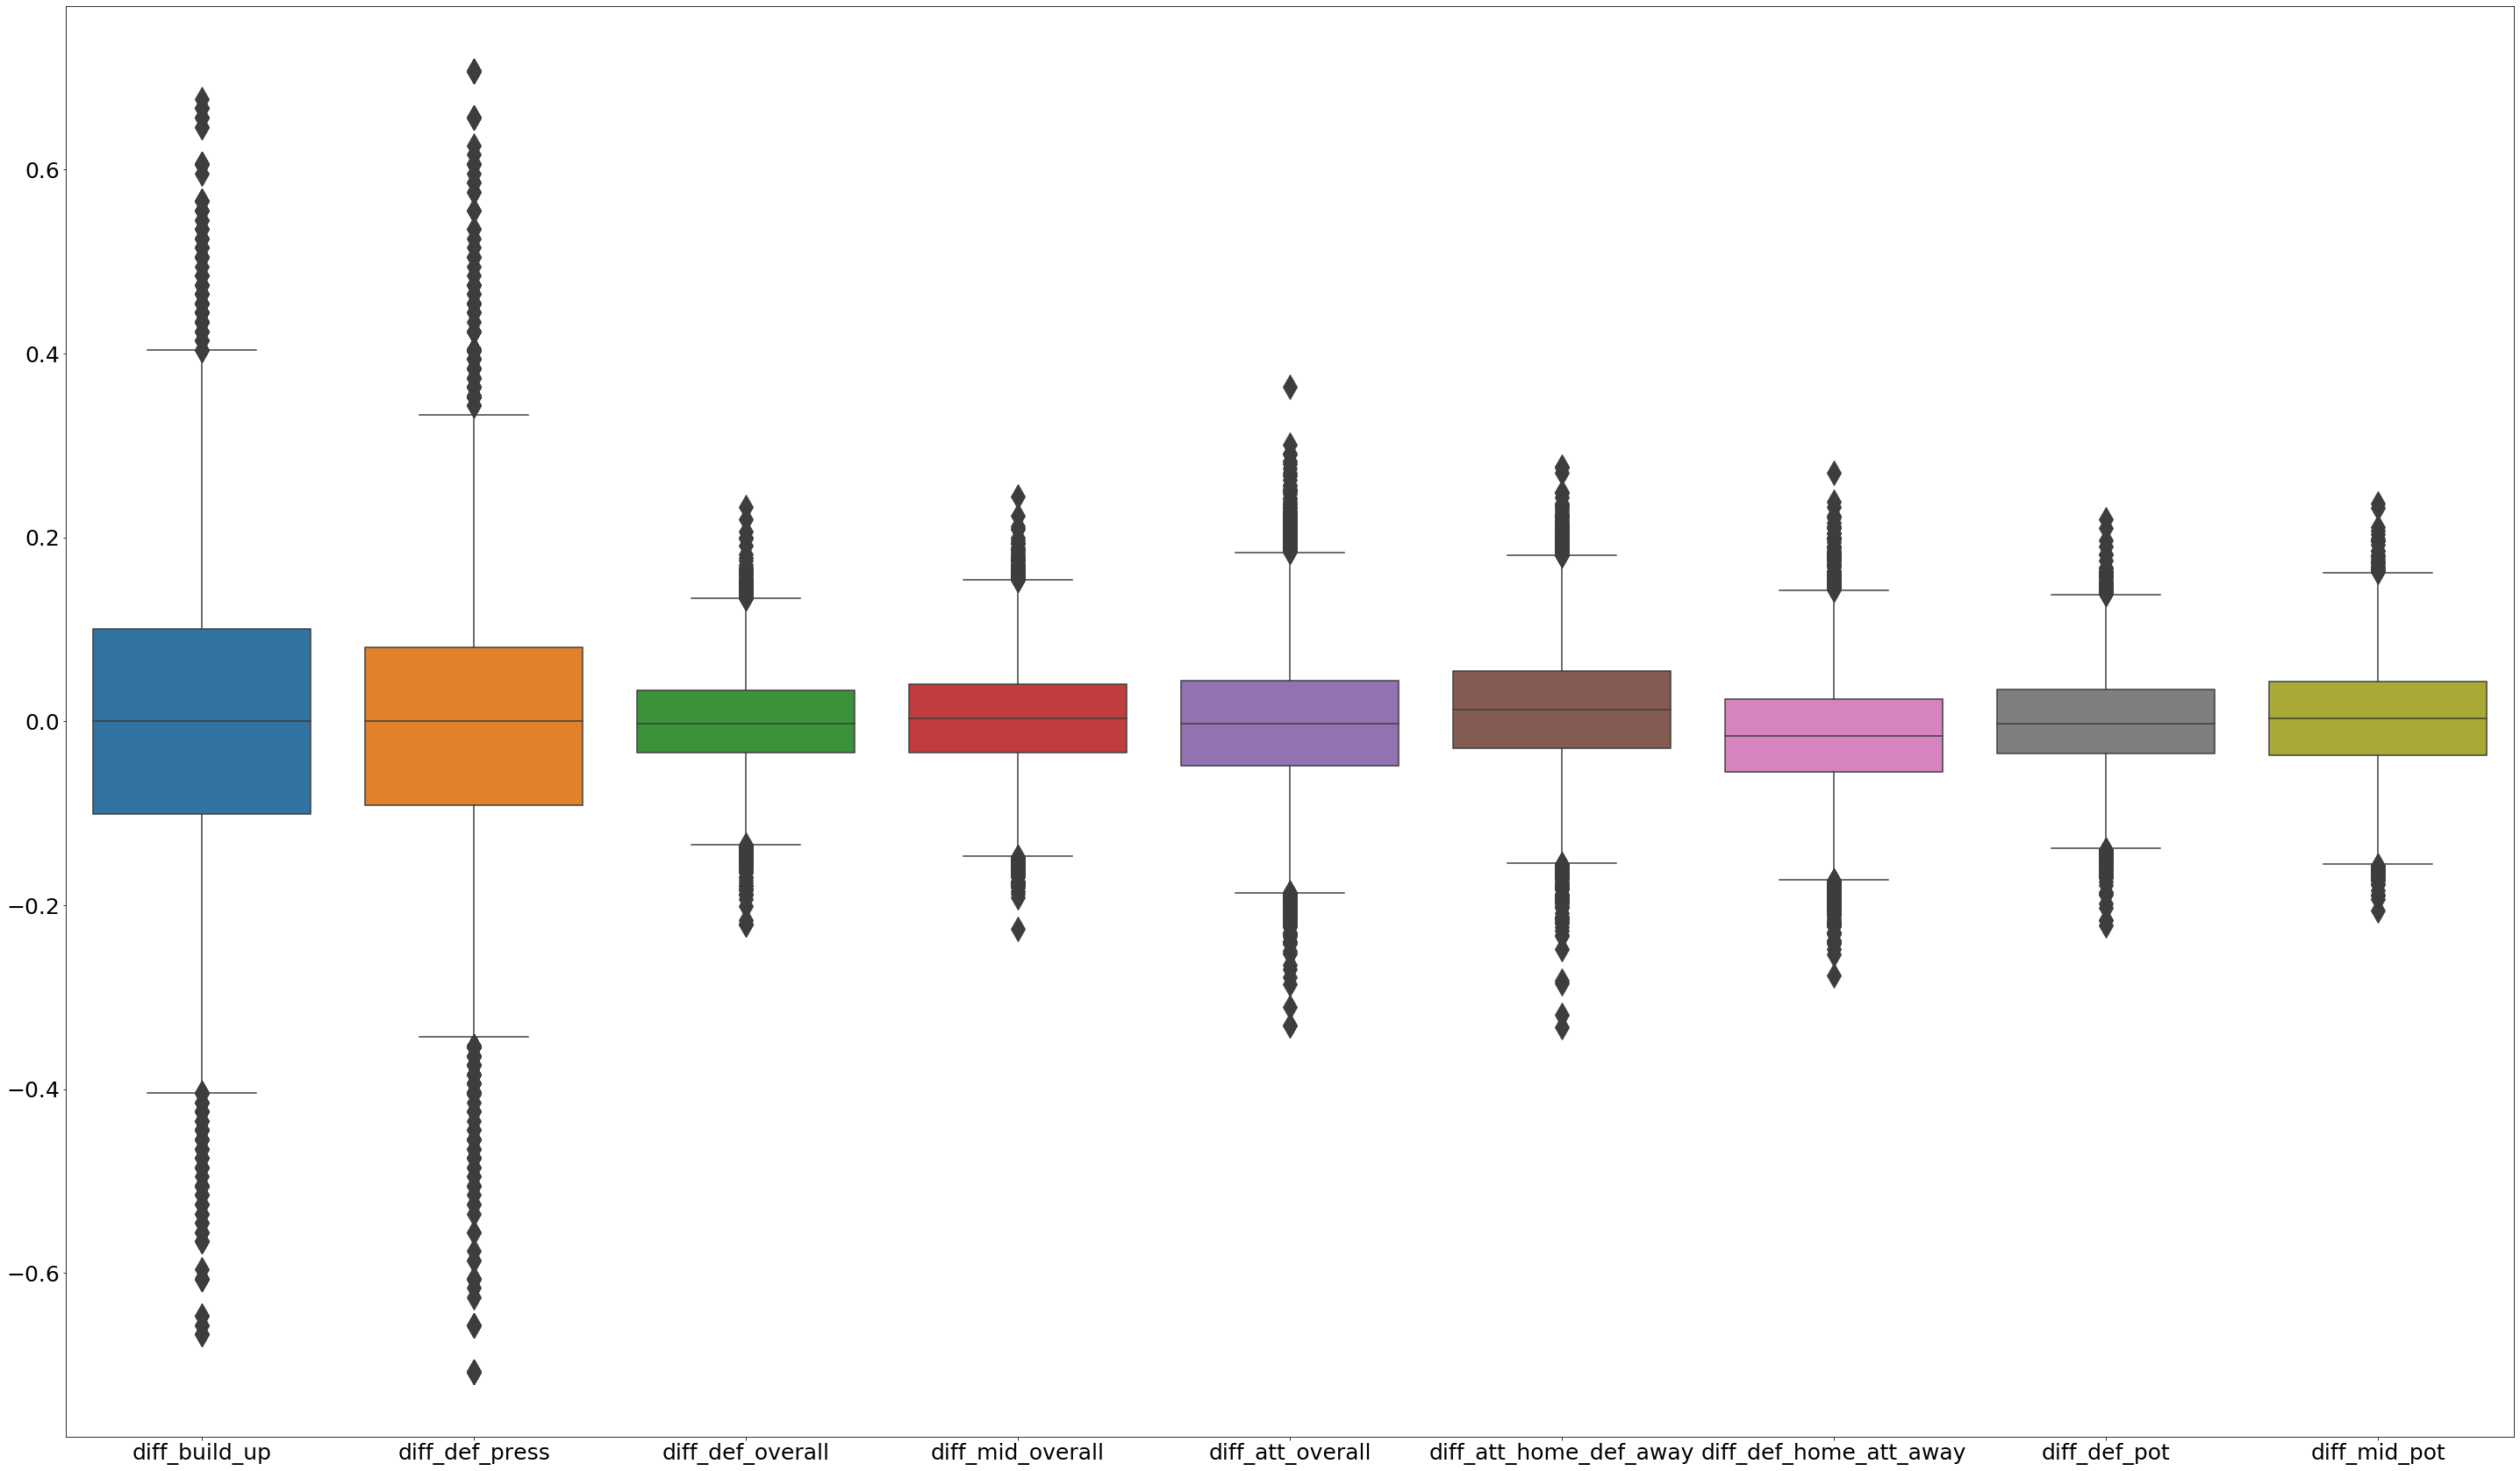

In [77]:

import matplotlib.pyplot as plt
import seaborn as sns

## PLOTING BOXPLOT
fig3,ax3 = plt.subplots(figsize=(50,30))
ax = sns.boxplot(data=matchsTrainNumVariables,fliersize=20)
ax.tick_params(labelsize=25)
plt.show()

### Distribution des différents variables via histogrammes

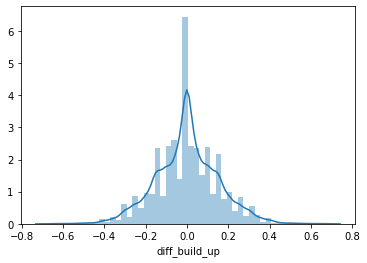

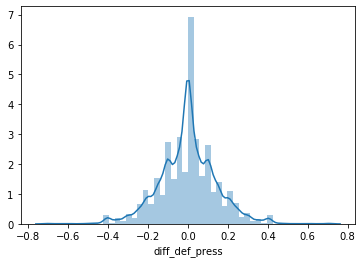

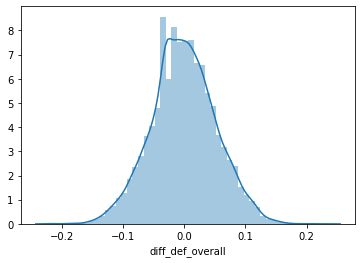

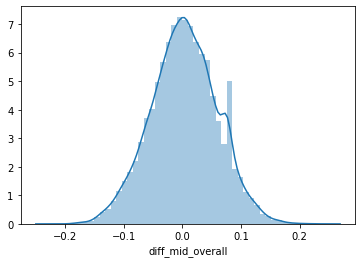

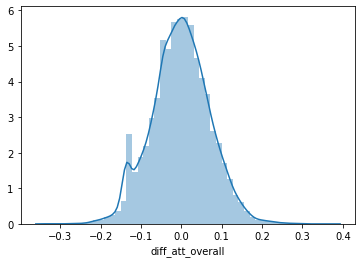

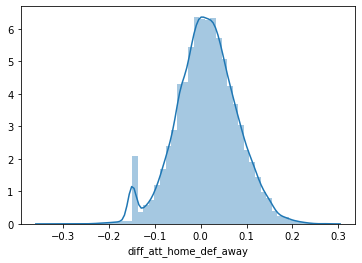

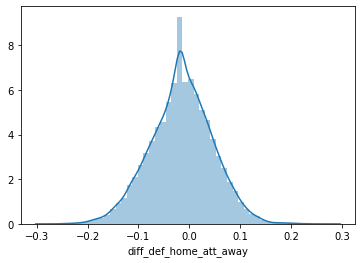

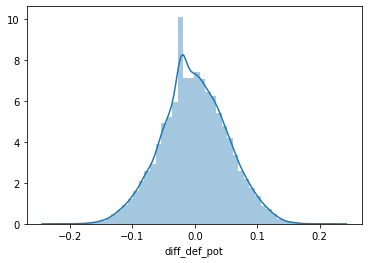

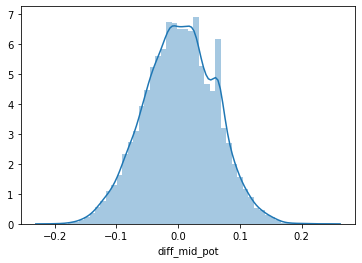

In [78]:

for i in range(0,matchsTrainNumVariables.shape[1]):
    plt.figure(i)
    sns.distplot(matchsTrainNumVariables.iloc[:,i])
    plt.show()

## Data Cleaning Final

In [ ]:
class Data_Cleaning:
    def __init__(self, matchs):
        self.matchs = matchs

    def run(self):

        # Récupérer toutes les features du type float64
        numerical_data = self.matchs.select_dtypes(["float64", 'int64'])
        num_attribs = list(numerical_data)
        # Changer le type des saisons d'objets à categorique

        # ,'home_team_name','away_team_name','home_form','away_form']
        categorical_attrib = ['season','home_form', 'away_form']
        self.matchs[categorical_attrib] = self.matchs[categorical_attrib].apply(
            lambda x: x.astype('category'))

        # Utilisation de pipeline pour clean les data

        num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('imputer', Imputer(strategy="median")),
            ('min_max_scaler', StandardScaler()),
        ])

        categorical_pipeline = Pipeline([
            ('selector', DataFrameSelector(categorical_attrib)),
            ('label_binazer', MyLabelBinarizer()),
        ])

        from sklearn.pipeline import FeatureUnion
        full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("categorical_pipeline", categorical_pipeline)
        ])

        # data are clean here
        match_cleaned = full_pipeline.fit_transform(self.matchs)
        return match_cleaned